In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import shutil
import os

# Replace with your actual dataset path
original_path = "/kaggle/input/ecg-analysis/ECG_DATA"
writable_path = "/kaggle/working/ECG_DATA"

# Copy the dataset to a writable directory
shutil.copytree(original_path, writable_path)
print("✅ Dataset copied to working directory.")

✅ Dataset copied to working directory.


In [18]:
import os
from pathlib import Path
from collections import Counter

# Directories
train_dir = Path('/kaggle/input/ecg-analysis/ECG_DATA/train')
test_dir = Path('/kaggle/input/ecg-analysis/ECG_DATA/test')

def count_images_in_classes(directory):
    print(f"\n📁 Folder: {directory.name}")
    class_counts = {}
    
    for class_folder in sorted(directory.iterdir()):
        if class_folder.is_dir():
            image_count = len(list(class_folder.glob('*')))
            class_counts[class_folder.name] = image_count
            print(f"  - {class_folder.name}: {image_count} images")
    
    total_images = sum(class_counts.values())
    print(f"\n✅ Total images in {directory.name}: {total_images}")
    return class_counts

# Count class samples
train_class_counts = count_images_in_classes(train_dir)
test_class_counts = count_images_in_classes(test_dir)



📁 Folder: train
  - ECG Images of Myocardial Infarction Patients (240x12=2880): 956 images
  - ECG Images of Patient that have History of MI (172x12=2064): 516 images
  - ECG Images of Patient that have abnormal heartbeat (233x12=2796): 699 images
  - Normal Person ECG Images (284x12=3408): 852 images

✅ Total images in train: 3023

📁 Folder: test
  - ECG Images of Myocardial Infarction Patients (240x12=2880): 239 images
  - ECG Images of Patient that have History of MI (172x12=2064): 172 images
  - ECG Images of Patient that have abnormal heartbeat (233x12=2796): 233 images
  - Normal Person ECG Images (284x12=3408): 284 images

✅ Total images in test: 928


Processing ECG Images of Myocardial Infarction Patients (240x12=2880) with label 0 ...
Processing ECG Images of Patient that have History of MI (172x12=2064) with label 1 ...
Processing ECG Images of Patient that have abnormal heartbeat (233x12=2796) with label 2 ...
Processing Normal Person ECG Images (284x12=3408) with label 3 ...
Processing ECG Images of Myocardial Infarction Patients (240x12=2880) with label 0 ...
Processing ECG Images of Patient that have History of MI (172x12=2064) with label 1 ...
Processing ECG Images of Patient that have abnormal heartbeat (233x12=2796) with label 2 ...
Processing Normal Person ECG Images (284x12=3408) with label 3 ...
Train shape: (2416, 224, 224, 1), Train labels shape: (2416,)
Test shape: (741, 224, 224, 1), Test labels shape: (741,)
Label mapping: {0: 'ECG Images of Myocardial Infarction Patients (240x12=2880)', 1: 'ECG Images of Patient that have History of MI (172x12=2064)', 2: 'ECG Images of Patient that have abnormal heartbeat (233x12=

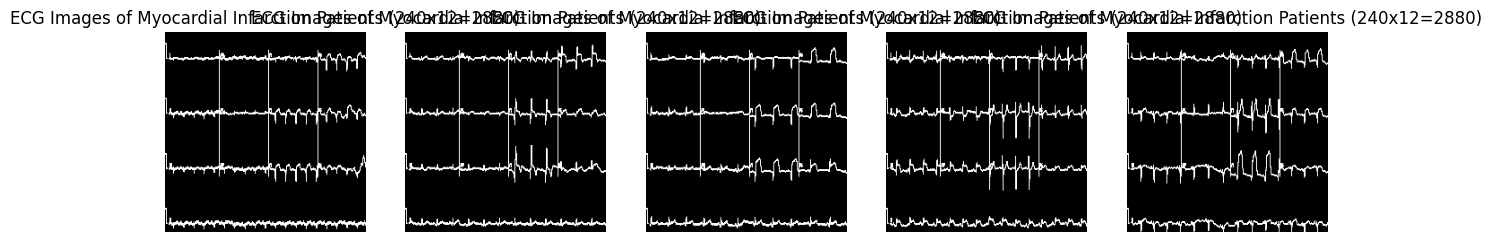

In [30]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

def preprocess_ecg_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape
    cropped = gray[int(height * 0.2):int(height * 0.9), int(width * 0.05):int(width * 0.95)]
    blurred = cv2.GaussianBlur(cropped, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)
    
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    dilated = cv2.dilate(thresh, kernel_dilate, iterations=1)
    
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel_close)
    
    resized = cv2.resize(closed, (224, 224))
    normalized = resized / 255.0
    return normalized, resized

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_image(image, path):
    cv2.imwrite(path, image)

def load_dataset(base_dir, save_processed_dir=None, valid_split=0.2):
    """
    base_dir: Directory containing the raw images organized in class subfolders.
    save_processed_dir: Base directory to save processed images.
    valid_split: Fraction of images to move to validation set.
    """
    X = []
    y = []
    label_map = {}

    folders = sorted([f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))])
    for idx, folder in enumerate(folders):
        label_map[idx] = folder
        folder_path = os.path.join(base_dir, folder)
        
        if save_processed_dir:
            save_train_folder = os.path.join(save_processed_dir, 'train', folder)
            save_valid_folder = os.path.join(save_processed_dir, 'valid', folder)
            ensure_dir(save_train_folder)
            ensure_dir(save_valid_folder)
        
        print(f"Processing {folder} with label {idx} ...")
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Split into train and validation sets
        train_files, valid_files = train_test_split(image_files, test_size=valid_split, random_state=42)
        
        # Process Training Images
        for fname in train_files:
            fpath = os.path.join(folder_path, fname)
            try:
                normalized_img, raw_processed_img = preprocess_ecg_image(fpath)
                X.append(normalized_img)
                y.append(idx)
                
                # Save to the processed folder
                if save_processed_dir:
                    save_image(raw_processed_img, os.path.join(save_train_folder, fname))
            except Exception as e:
                print(f"Failed to process {fpath}: {e}")
        
        # Process Validation Images
        for fname in valid_files:
            fpath = os.path.join(folder_path, fname)
            try:
                _, raw_processed_img = preprocess_ecg_image(fpath)
                
                # Save to the processed folder
                if save_processed_dir:
                    save_image(raw_processed_img, os.path.join(save_valid_folder, fname))
            except Exception as e:
                print(f"Failed to process {fpath}: {e}")

    X = np.array(X).reshape(-1, 224, 224, 1)
    y = np.array(y)
    return X, y, label_map


# Paths
train_dir = '/kaggle/input/ecg-analysis/ECG_DATA/train'
test_dir = '/kaggle/input/ecg-analysis/ECG_DATA/test'

# Directory to save processed images
processed_base_dir = './processed'

# Load datasets and save processed images
X_train, y_train, train_label_map = load_dataset(train_dir, save_processed_dir=processed_base_dir)
X_test, y_test, test_label_map = load_dataset(test_dir, save_processed_dir=processed_base_dir)

print(f"Train shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test shape: {X_test.shape}, Test labels shape: {y_test.shape}")
print("Label mapping:", train_label_map)

# Display some test images with labels
def display_test_samples(X, y, label_map, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img = X[i].squeeze()
        plt.imshow(img, cmap='gray')
        plt.title(label_map[y[i]])
        plt.axis('off')
    plt.show()

display_test_samples(X_test, y_test, test_label_map, num_samples=5)


In [34]:
import os
from collections import Counter

def count_images_in_directory(base_dir):
    """
    Counts the number of images per class in a given directory.
    
    Args:
    - base_dir (str): Path to the base directory containing class subfolders.

    Returns:
    - class_counts (dict): A dictionary with class names as keys and image counts as values.
    - total_images (int): Total number of images across all classes.
    """
    class_counts = Counter()
    total_images = 0
    
    # Loop through each class folder
    folders = sorted([f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))])
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        
        # Count images in each class folder
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[folder] = len(image_files)
        total_images += len(image_files)
    
    return class_counts, total_images

# Directories after preprocessing
train_dir = './processed/train'
valid_dir = './processed/valid'
test_dir = './processed/test'

# Get counts for each dataset
train_counts, total_train = count_images_in_directory(train_dir)
valid_counts, total_valid = count_images_in_directory(valid_dir)
test_counts, total_test = count_images_in_directory(test_dir)

# Display the results
print("\n===== Image Counts per Class =====")
print("\nTraining Set Counts:", dict(train_counts))
print("\nValidation Set Counts:", dict(valid_counts))
print("\nTest Set Counts:", dict(test_counts))

print("\n===== Total Image Counts =====")
print(f"Total Training Images: {total_train}")
print(f"Total Validation Images: {total_valid}")
print(f"Total Test Images: {total_test}")



===== Image Counts per Class =====

Training Set Counts: {'ECG Images of Myocardial Infarction Patients (240x12=2880)': 956, 'ECG Images of Patient that have History of MI (172x12=2064)': 516, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 699, 'Normal Person ECG Images (284x12=3408)': 852}

Validation Set Counts: {'ECG Images of Myocardial Infarction Patients (240x12=2880)': 228, 'ECG Images of Patient that have History of MI (172x12=2064)': 132, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 182, 'Normal Person ECG Images (284x12=3408)': 217}

Test Set Counts: {'ECG Images of Myocardial Infarction Patients (240x12=2880)': 239, 'ECG Images of Patient that have History of MI (172x12=2064)': 172, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 233, 'Normal Person ECG Images (284x12=3408)': 284}

===== Total Image Counts =====
Total Training Images: 3023
Total Validation Images: 759
Total Test Images: 928
